In [1]:
from models import MeshModel, IcosphereModel
from models.mesh_transform import transform
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from geometry import clip, polygon_area
from geometry.utils import wrap
from jax.typing import ArrayLike
import jax

from jax import config
config.update("jax_enable_x64", True)

sol_rad = u.solRad.to(u.cm)

m1 = IcosphereModel.construct(1000, u.solRad.to(u.cm), 1., 1., jnp.concatenate([jnp.array([3.75]), jnp.ones(19)]))
m2 = transform(IcosphereModel.construct(1000, u.solRad.to(u.cm), 1., 1., jnp.concatenate([jnp.array([3.75]), jnp.ones(19)])), sol_rad)

In [2]:
def visible_area(vertices1: ArrayLike, vertices2: ArrayLike) -> ArrayLike:
    clipped = jnp.nan_to_num(clip(vertices1, vertices2))
    return polygon_area(clipped[:, 0], clipped[:, 1])

total_visible_area = jax.jit(jax.vmap(visible_area, in_axes=(None, 0)))
visibility_areas = jax.jit(jax.vmap(total_visible_area, in_axes=(0, None)))

total_cropped = jax.jit(jax.vmap(visible_area, in_axes=(0, None)))
occluded = jax.jit(jax.vmap(total_cropped, in_axes=(None, 0)))

In [3]:
t1 = jnp.array([[1., 1.],
                [1., 3.],
                [3., 3.]])
t2 = jnp.array([[2., 2.5],
                [4., 2.5],
                [2., 3.5]])
t3 = jnp.array([[2., 1.],
                [2., 2.5],
                [4., 2.5]])

In [4]:
clip(t3, t1)

Array([[2.5, 2.5],
       [2. , 2.5],
       [2. , 2. ],
       [2. , 2. ],
       [2. , 2. ],
       [2. , 2. ]], dtype=float64)

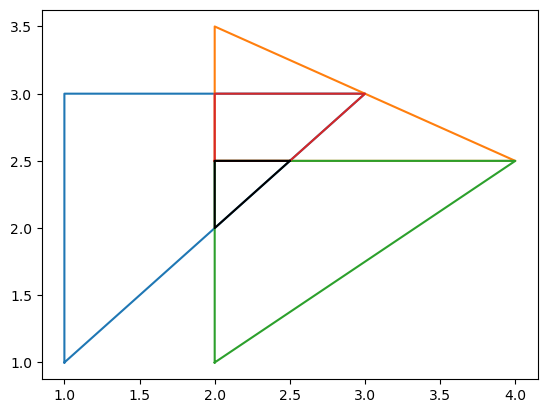

In [5]:
plt.plot(wrap(t1)[:, 0], wrap(t1)[:, 1])
plt.plot(wrap(t2)[:, 0], wrap(t2)[:, 1])
plt.plot(wrap(t3)[:, 0], wrap(t3)[:, 1])

t1t2 = jnp.nan_to_num(clip(t1, t2))
plt.plot(wrap(t1t2)[:, 0], wrap(t1t2)[:, 1]),
t1t3 = jnp.nan_to_num(clip(t3, t1))
plt.plot(wrap(t1t3)[:, 0], wrap(t1t3)[:, 1], color='black')

In [22]:
t1 = jnp.array([[1., 1.],
                [1., 3.],
                [3., 3.]])
t2 = jnp.copy(t1)
total_visible_area(t1, jnp.stack([t2]))

Array([2.], dtype=float64)

In [23]:
t1 = jnp.array([[1., 1.],
                [1., 3.],
                [3., 3.]])
t2 = 10*jnp.copy(t1)
total_visible_area(t1, jnp.stack([t2]))

Array([0.], dtype=float64)

In [7]:
tva = total_visible_area(t1, jnp.stack([t2, t3]))

In [8]:
jnp.sum(tva)

Array(0.5, dtype=float64)

[]

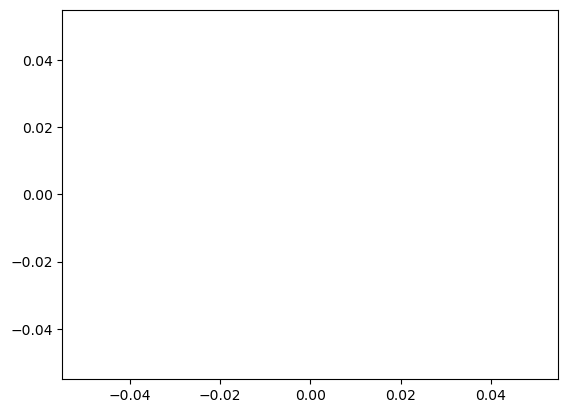

In [9]:
plt.plot()

In [10]:
vs1 = m1.vertices[m1.faces[m1.mus>0].astype(int)]
vs2 = m2.vertices[m2.faces[m2.mus>0].astype(int)]
projected_areas = jax.jit(jax.vmap(polygon_area))
pa = projected_areas(vs1[:, :, 0], vs1[:, :, 2])

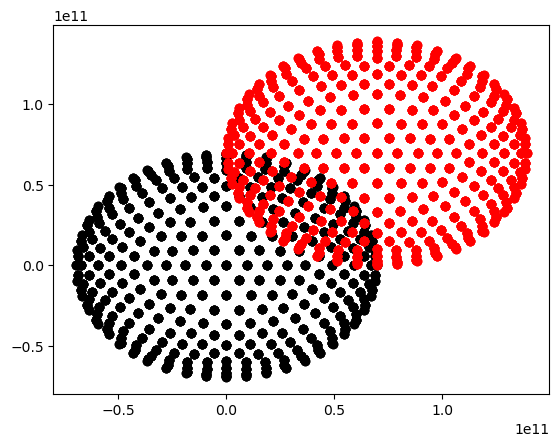

In [11]:
plt.scatter(vs1[:, :, 0], vs1[:, :, 2], c='black')
plt.scatter(vs2[:, :, 0], vs2[:, :, 2], c='red')

In [12]:
a = visibility_areas(vs1[:, :, [0, 2]], vs2[:, :, [0, 2]])
o = occluded(vs1[:, :, [0, 2]], vs2[:, :, [0, 2]])

In [13]:
jnp.max(a)

Array(1.93049825e+19, dtype=float64)

In [14]:
jnp.max(m1.areas[m1.mus>0])>0

Array(True, dtype=bool)

In [15]:
vs1[:, :, 0].shape, jnp.sum(a, axis=0).shape

((624, 3), (624,))

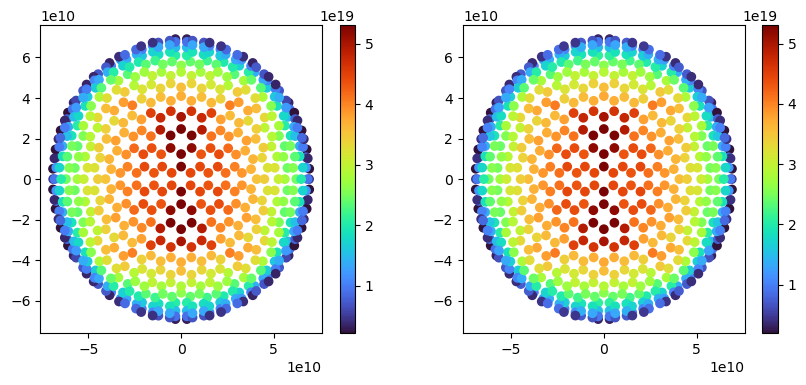

In [16]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
p1 = ax[0].scatter(m1.centers[m1.mus>0, 0], m1.centers[m1.mus>0, 2], c=projected_areas(vs1[:, :, 0], vs1[:, :, 2]), cmap='turbo')
plt.colorbar(p1, ax=ax[0])
p2 = ax[1].scatter(m1.centers[m1.mus>0, 0], m1.centers[m1.mus>0, 2], c=m1.mus[m1.mus>0]*m1.areas[m1.mus>0], cmap='turbo')
plt.colorbar(p2, ax=ax[1])

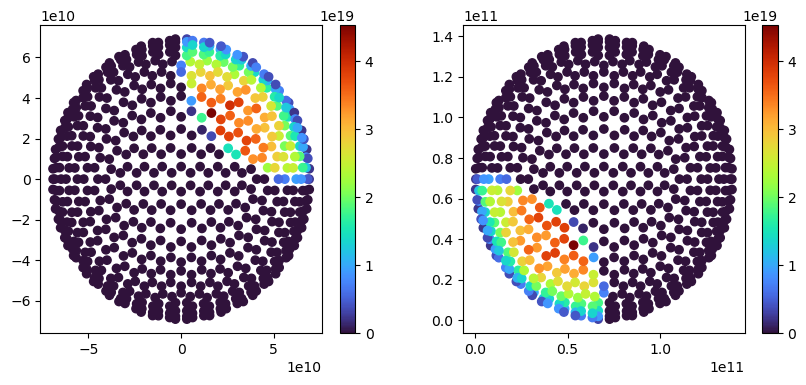

In [17]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
p1 = ax[0].scatter(m1.centers[m1.mus>0, 0], m1.centers[m1.mus>0, 2], c=jnp.sum(a, axis=1), cmap='turbo')
plt.colorbar(p1, ax=ax[0])
p2 = ax[1].scatter(m2.centers[m2.mus>0, 0], m2.centers[m2.mus>0, 2], c=jnp.sum(o, axis=1), cmap='turbo')
plt.colorbar(p2, ax=ax[1])

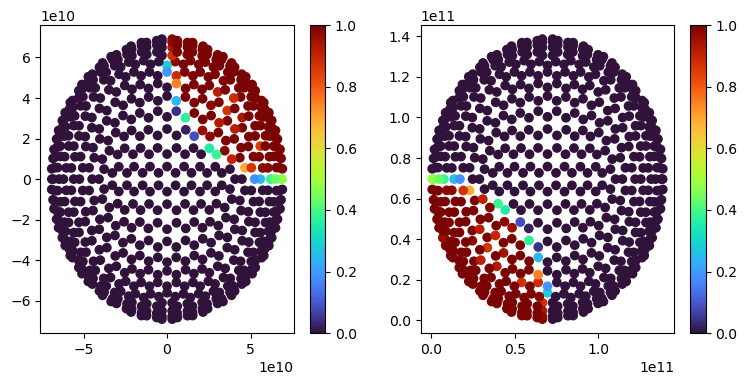

In [18]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))
p1 = ax[0].scatter(m1.centers[m1.mus>0, 0], m1.centers[m1.mus>0, 2], c=jnp.clip(jnp.sum(a, axis=1)/projected_areas(vs1[:, :, 0], vs1[:, :, 2]), 0, 1), cmap='turbo')
plt.colorbar(p1, ax=ax[0])
p2 = ax[1].scatter(m2.centers[m2.mus>0, 0], m2.centers[m2.mus>0, 2], c=jnp.clip(jnp.sum(o, axis=1)/projected_areas(vs2[:, :, 0], vs2[:, :, 2]), 0, 1), cmap='turbo')
plt.colorbar(p2, ax=ax[1])

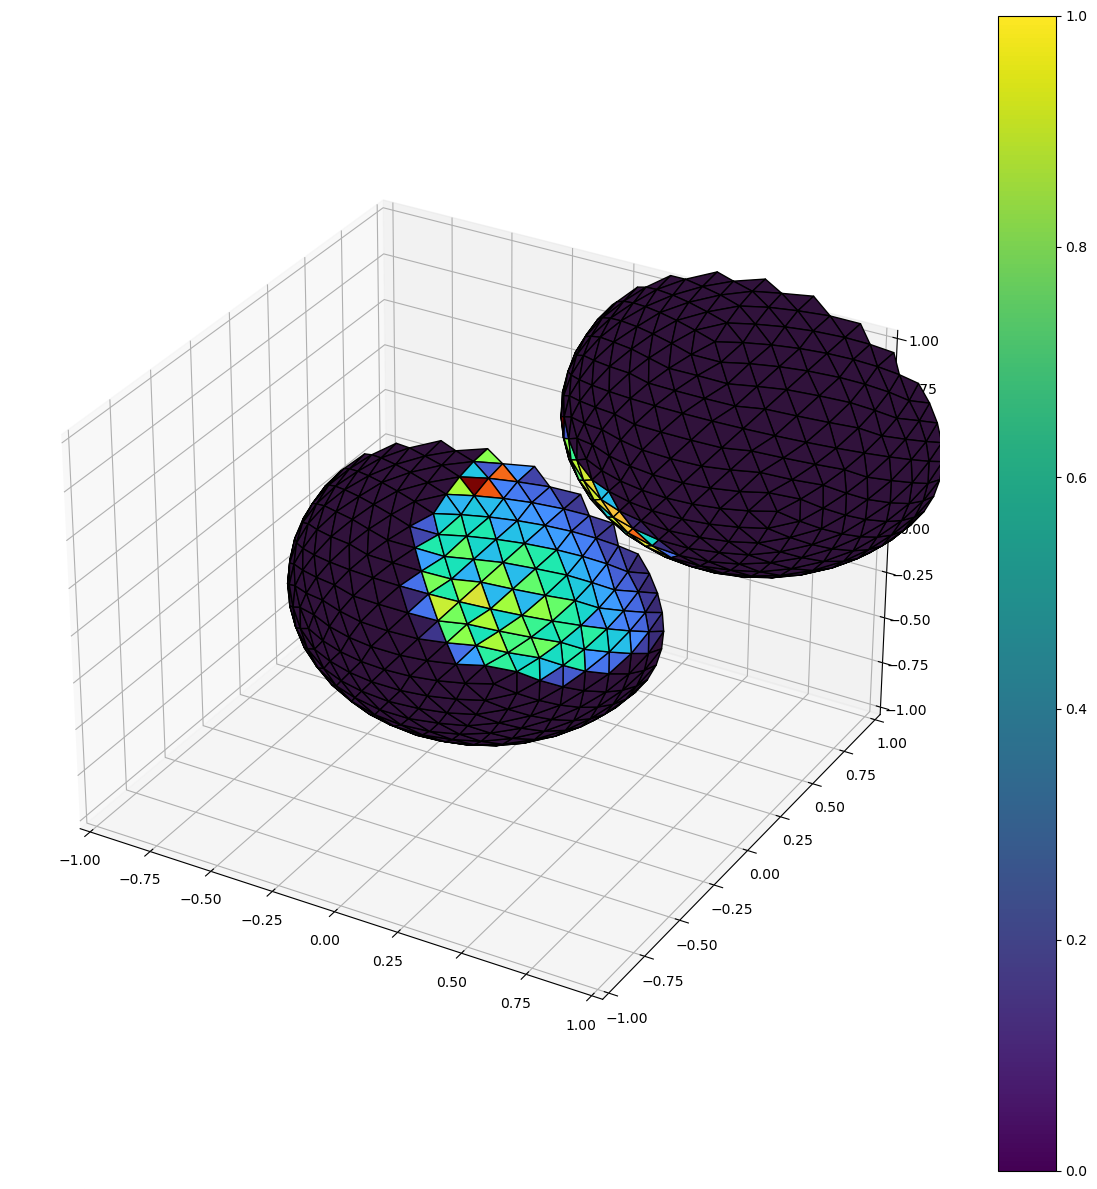

In [87]:
from mpl_toolkits.mplot3d import Axes3D, art3d
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(projection="3d")
c=jnp.sum(a, axis=1)
# c=jnp.clip(jnp.sum(a, axis=1)/projected_areas(vs1[:, :, 0], vs1[:, :, 2]), 0, 1)
n = plt.Normalize(np.min(c), np.max(c))
on = plt.Normalize(np.min(o), np.max(o))

pc = art3d.Poly3DCollection(vs1, facecolors=plt.cm.turbo(n(c)), edgecolor="black")
ax.add_collection(pc)

pc2 = art3d.Poly3DCollection(vs2, facecolors=plt.cm.turbo(on(jnp.sum(o, axis=1))), edgecolor="black")
ax.add_collection(pc2)
ax.set_xlim(-1e11, 1e11)
ax.set_ylim(-1e11, 1e11)
ax.set_zlim(-1e11, 1e11)
plt.colorbar(pc)

In [ ]:
jnp.sum(a, axis=0).shape, vs1[:, :, 0].shape

((624,), (624, 3))

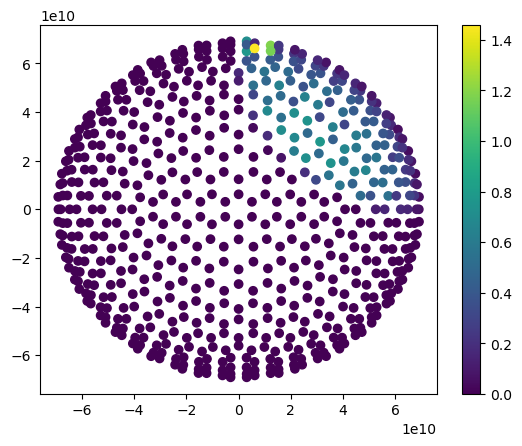

In [ ]:
plt.scatter(m1.centers[m1.mus>0, 0], m1.centers[m1.mus>0, 2], c=(jnp.sum(a, axis=1)/m1.areas[m1.mus>0]))
plt.colorbar()

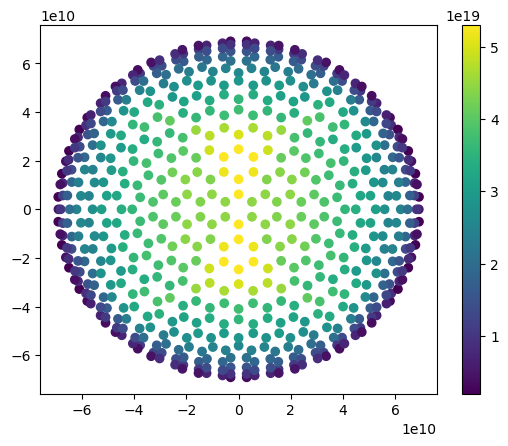

In [ ]:
plt.scatter(m1.centers[m1.mus>0, 0], m1.centers[m1.mus>0, 2], c=m1.areas[m1.mus>0]*m1.mus[m1.mus>0])
plt.colorbar()

In [ ]:
plt.scatter(m1.centers[m1.centers[:, 2]>0, 0], m1.centers[m1.centers[:, 2]>0, 1], c=jnp.sum(a, axis=1)[m1.centers[:, 2]>0]/m1.areas[m1.centers[:, 2]>0])
#plt.scatter(m2.centers[:, 0]+sol_rad, m2.centers[:, 1]+sol_rad, c='red')
plt.colorbar()

IndexError: boolean index did not match shape of indexed array in index 0: got (1280,), expected (624,)

In [ ]:
m1.vertices[0, :2].reshape((1, 2))

Array([[-3.65751117e+10,  5.91797753e+10]], dtype=float64)

In [ ]:
v1 = m1.vertices[m1.faces.astype(int)[0], :2]
v2 = m2.vertices[m2.faces.astype(int)[0], :2]+sol_rad

In [ ]:
a = total_visible_area(v1, m2.vertices[m2.faces.astype(int), :2]+sol_rad)

In [ ]:
a = visibility_areas(m1.vertices[m1.faces.astype(int), :2], m2.vertices[m2.faces.astype(int), :2]+sol_rad)

(1280, 1280)

In [ ]:
jnp.max(a)

Array(7.50535064e+19, dtype=float64)

In [ ]:
visibility_areas(m1.vertices[m1.faces.astype(int), :2], m2.vertices[m2.faces.astype(int), :2]+sol_rad)

Array([[3.56865932e+18, 3.56865932e+18, 3.56865932e+18, ...,
        3.56865932e+18, 3.56865932e+18, 3.56865932e+18],
       [7.12174457e+18, 7.12174457e+18, 7.12174457e+18, ...,
        7.12174457e+18, 7.12174457e+18, 7.12174457e+18],
       [9.31756853e+18, 9.31756853e+18, 9.31756853e+18, ...,
        9.31756853e+18, 9.31756853e+18, 9.31756853e+18],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [4.56335490e+18, 4.56335490e+18, 4.56335490e+18, ...,
        4.56335490e+18, 4.56335490e+18, 4.56335490e+18],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]], dtype=float64)

In [ ]:
jnp.min(a, axis=1)

Array([ 3.56865932e+18,  7.12174457e+18,  9.31756853e+18, ...,
        0.00000000e+00,  2.14971555e+18, -1.04857600e+06], dtype=float64)